<a href="https://colab.research.google.com/github/Camilojaravila/202310_MINE-4206_ANALISIS_CON_MACHINE_LEARNING/blob/main/Laboratorio%202/Sesi%C3%B3n%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

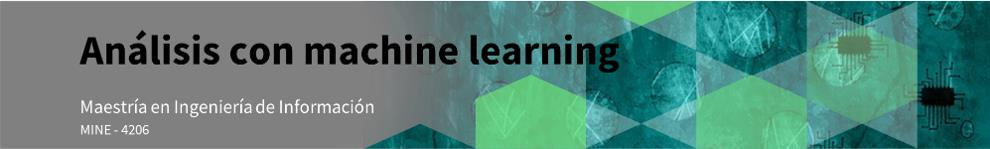

Según la Organización Mundial de la Salud , las enfermedades
cardiovasculares (ECV) son la principal causa de muerte en todo el
mundo, y se estima que, para el 2030, 23,6 millones de personas
morirán por alguna enfermedad de este tipo. Las ECV son un grupo de
trastornos del corazón y de los vasos sanguíneos que incluyen, entre
otras afecciones, a la enfermedad coronaria, enfermedad
cerebrovascular y enfermedad cardíaca reumática. Cuatro de cada 5
muertes por ECV se deben a ataques cardíacos y accidentes
cerebrovasculares, y un tercio de estas muertes ocurren
prematuramente en personas menores de 70 años. Un pronóstico
temprano podría ayudar a tomar decisiones sobre los cambios en el
estilo de vida en pacientes de alto riesgo y, a su vez, reducir las
complicaciones.
En este sentido, se quiere llevar a cabo un estudio, tomando como base
los datos de los pacientes registrados en una institución médica, que
utilice técnicas de machine learning para la construcción de modelos
que, no solo aporten en la identificación de los factores que más
inciden en el padecimiento de enfermedad cardíaca, sino también
puedan predecir qué pacientes están en riesgo de sufrir una ECV.


Objetivos:
* Construir un modelo de clasificación.
* Determinar las métricas de los modelos de clasificación.
* Establecer la selección del modelo basado en métricas y gráficas.

## 0. Importación de Librerías.

Para el desarrollo en Google Colab, y poder ejecutar la librería de Pandas-Profiling, debemos ejecutar el siguiente código.


In [31]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py) ... done


Para este ejercicio, utilizaremos las siguientes librerías.

In [32]:
#Manejo de datos
import pandas as pd
import numpy as np

#Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Analisis profundo de datos
from pandas_profiling import ProfileReport

#Entrenamiento del modelo
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

#Librerías extras
import itertools


## 1. Entendimiento del Negocio

Luego de hablar con el equipo del censo, le preguntamos que significaba cada una de las variables que había logrado capturar en la encuesta. Dándonos los siguientes resultados:

There are 3 types of input features:

Objective: factual information.

Examination: results of medical examination.

Subjective: information given by the patient.

Features:

|Description | Feature | Name | Type |
|---|---|---|---|
|Age | Objective Feature | age | int (days) |
|Height | Objective Feature | height | int (cm) |
|Weight | Objective Feature | weight | float (kg) |
|Gender | Objective Feature | gender | categorical code |
|Systolic blood pressure | Examination Feature | ap_hi | int positive |
|Diastolic blood pressure | Examination Feature | ap_lo | int positive |
|Cholesterol | Examination Feature | cholesterol | normal, above normal, well above normal |
|Glucose | Examination Feature | gluc | normal, above normal, well above normal |
|Smoking | Subjective Feature | smoke | binary |
|Alcohol intake | Subjective Feature | alco | binary |
|Physical activity | Subjective Feature | active | binary |
|Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All the dataset values were collected at the moment of medical examination.

## 2. Entendimiento de los Datos

Luego de entender el negocio y su objetivo, vamos a realizar la exploración de datos. Así que, leeremos los datos.

In [33]:
url = 'https://raw.githubusercontent.com/Camilojaravila/202210_MINE-4206_ANALISIS_CON_MACHINE_LEARNING/main/Taller%202/Cardiovascular%20disease.csv'

data = pd.read_csv(url, sep=";")
data.head() #Veremos las primeras líneas del dataset, para ver si leyó correctamente

,age,gender,height,weight,systolic blood pressure,diastolic blood pressure,cholesterol,glucose,smoke,Alcohol,active,ECV
0,18393,2.0,168,62.0,110,80,normal,normal,0,0,1,0
1,20228,1.0,156,85.0,140,90,well above normal,normal,0,0,1,1
2,18857,1.0,165,64.0,130,70,well above normal,normal,0,0,0,1
3,17623,2.0,169,82.0,150,100,normal,normal,0,0,1,1
4,17474,1.0,156,56.0,100,60,normal,normal,0,0,0,0


Primero necesitaremos dividir nuestros datos en datos de entrenamiento (train) y datos de evaluación (test). Para poder comparar los resultados con nuestra sesión anterior, utilizaremos la misma proporción de datos de entrenamiento, así como la misma semilla. 

In [34]:
train, test = train_test_split(data, test_size=0.2, random_state=33)
train.head()

,age,gender,height,weight,systolic blood pressure,diastolic blood pressure,cholesterol,glucose,smoke,Alcohol,active,ECV
49832,19982,1.0,169,70.0,140,90,well above normal,normal,0,0,1,1
29318,22013,1.0,151,65.0,140,90,normal,normal,0,0,1,0
53073,16758,1.0,164,92.0,160,95,normal,normal,0,0,1,1
18039,17515,2.0,172,96.0,130,90,normal,normal,0,1,1,1
38740,21291,1.0,152,38.0,150,1000,normal,normal,0,0,1,1


Utilizaremos la libreria de `pandas-profiling` para realizar una exploración de datos más profunda

In [35]:
ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Preparación de los datos

Como lo vimos en la clase, nuestra variable target es $ECV$, mientras que los demás atributos serán los que nos ayudarán a determinar esta clase.

In [36]:
X_train, y_train = train.drop(['ECV'],axis=1), train['ECV'] 
display(X_train)
y_train

,age,gender,height,weight,systolic blood pressure,diastolic blood pressure,cholesterol,glucose,smoke,Alcohol,active
49832,19982,1.0,169,70.0,140,90,well above normal,normal,0,0,1
29318,22013,1.0,151,65.0,140,90,normal,normal,0,0,1
53073,16758,1.0,164,92.0,160,95,normal,normal,0,0,1
18039,17515,2.0,172,96.0,130,90,normal,normal,0,1,1
38740,21291,1.0,152,38.0,150,1000,normal,normal,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
65593,18120,2.0,167,50.0,100,60,above normal,normal,1,0,1
27849,20732,1.0,167,117.0,135,80,above normal,normal,0,0,1
578,18935,2.0,160,63.0,170,90,normal,normal,0,0,0
67975,21247,2.0,174,78.0,180,110,well above normal,normal,1,0,1


49832    1
29318    0
53073    1
18039    1
38740    1
        ..
65593    1
27849    1
578      1
67975    1
23572    0
Name: ECV, Length: 55997, dtype: int64

##4. Modelado

Como ya vimos como 'automatizar' nuestro flujo de datos, vamos a construir un Pipeline que se encargará de realizar la transformación de nuestros datos a variables numéricas, realizaremos un imputer sencillo para estos datos que no se encuentran en nuestro entrenamiento y con ello podremos entrenar nuestro clasificador

In [37]:
%%time
estimators = [
        ('encoder',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('regression', LogisticRegression())          
    ]

pipe_LR = Pipeline(estimators)

pipe_LR.fit(X_train, y_train)

CPU times: user 1.15 s, sys: 420 ms, total: 1.57 s
Wall time: 1.65 s


Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('regression', LogisticRegression())])

In [38]:
y_pred_train_LR = pipe_LR.predict(X_train)
y_pred_train_LR

array([1, 1, 1, ..., 1, 1, 0])

Y ya con nuestros clasificadores entrenados, podemos establecer nuestra **Matriz de Confusión**

In [39]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,size=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization


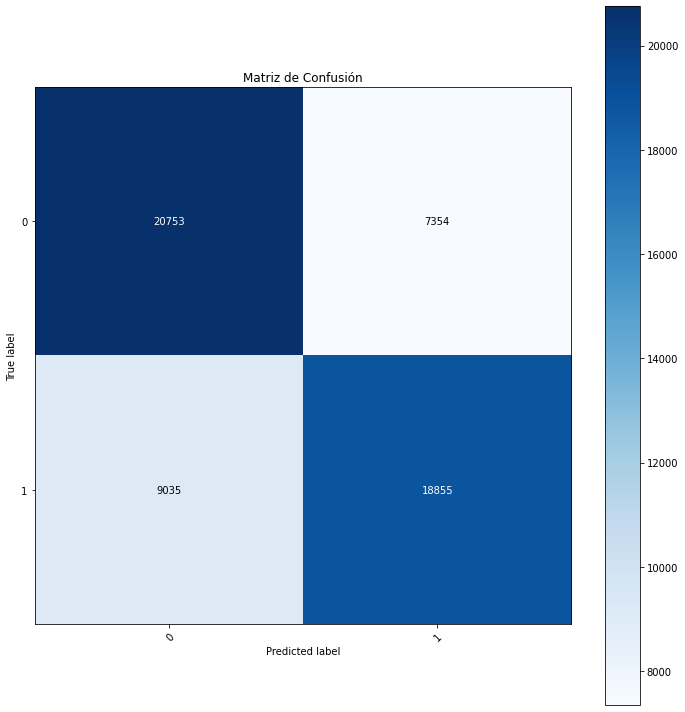

In [40]:
%matplotlib inline
plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train_LR, classes=[0,1],
                      title='Matriz de Confusión')

Normalized confusion matrix


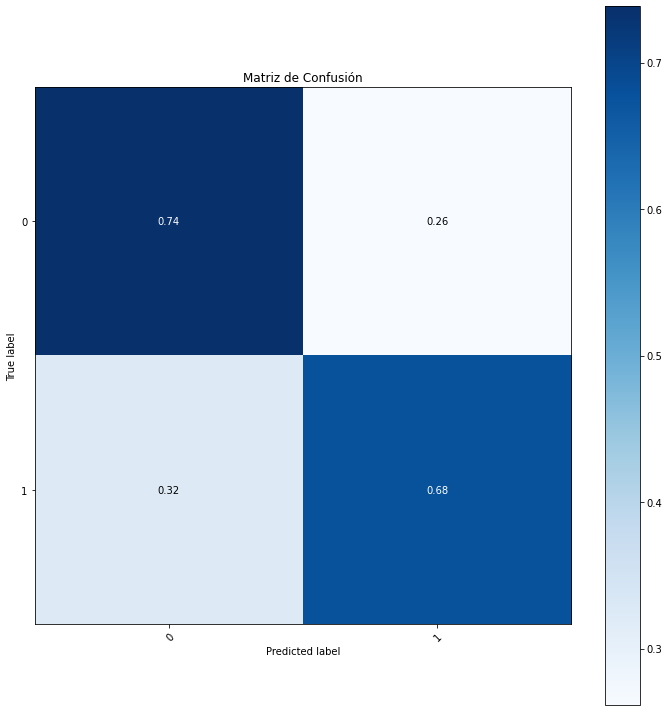

In [41]:
%matplotlib inline
plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train_LR, classes=[0,1], normalize=True,
                      title='Matriz de Confusión')

In [42]:
report_LR = classification_report(y_train, y_pred_train_LR)

print("Train Report for Logistic Regression\n", report_LR)
#tMatriz de confusión (Train y test)

Train Report for Logistic Regression
               precision    recall  f1-score   support

           0       0.70      0.74      0.72     28107
           1       0.72      0.68      0.70     27890

    accuracy                           0.71     55997
   macro avg       0.71      0.71      0.71     55997
weighted avg       0.71      0.71      0.71     55997



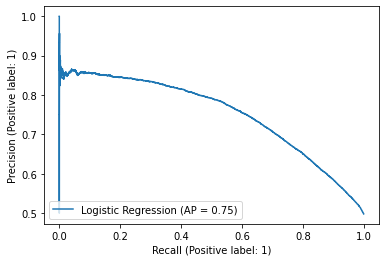

In [43]:
%matplotlib inline
PrecisionRecallDisplay.from_estimator(pipe_LR, X_train, y_train, name="Logistic Regression")
plt.show()

In [44]:
def display_multiple_models_roc_curve(models, X, y):
    # Below for loop iterates through your models list
    for m in models:
        model = m['model'] # select the model
        y_pred=model.predict(X) # predict the test data
    # Compute False postive rate, and True positive rate
        fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(y,y_pred)
    # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    # Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display

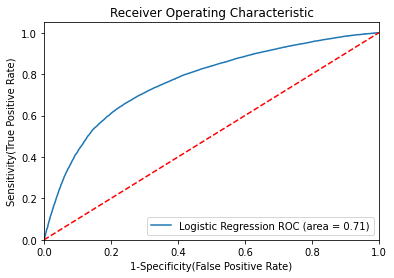

In [45]:
models = [
    {
        'label': 'Logistic Regression',
        'model': pipe_LR,
    }
]

display_multiple_models_roc_curve(models, X_train, y_train)

### Búsqueda de Hiperparámetros

In [46]:
estimators = [
        ('encoder',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('imputer',SimpleImputer(strategy='most_frequent', fill_value=-1)),
        ('normalization', StandardScaler()),
        ('regression', LogisticRegression())          
    ]

pipe_new = Pipeline(estimators)

parameters = {
            'encoder': [OneHotEncoder(handle_unknown='ignore'), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)],
            'imputer__strategy':  ['most_frequent', 'constant'],
            'normalization': [StandardScaler(), MinMaxScaler(), 'passthrough'],
            'regression__C': [0.01, 0.1, 1, 10, 100],
              
              
              }

grid_search = GridSearchCV(pipe_new, parameters, verbose=2, scoring='accuracy', cv=5)


In [47]:
%%time
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=StandardScaler(), regression__C=0.01; total time=   2.4s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=StandardScaler(), regression__C=0.01; total time=   4.3s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=StandardScaler(), regression__C=0.01; total time=   3.0s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=StandardScaler(), regression__C=0.01; total time=   2.9s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=StandardScaler(), regression__C=0.01; total time=   2.7s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=StandardScaler(), regression_

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.1; total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.1; total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.1; total time=   1.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.1; total time=   2.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.1; total time=   2.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=1; total time=   2.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=1; total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=1; total time=   1.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=1; total time=   1.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=1; total time=   1.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=10; total time=   2.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=10; total time=   2.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=10; total time=   2.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=10; total time=   1.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=10; total time=   1.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=100; total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=100; total time=   2.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=100; total time=   2.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=100; total time=   4.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=most_frequent, normalization=passthrough, regression__C=100; total time=   1.9s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=StandardScaler(), regression__C=0.01; total time=   0.1s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=StandardScaler(), regression__C=0.01; total time=   0.1s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=StandardScaler(), regression__C=0.01; total time=   0.1s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=StandardScaler(), regression__C=0.01; total time=   0.1s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=StandardScaler(), regression__C=0.01; total time=   0.1s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer_

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=0.1; total time=   1.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=0.1; total time=   1.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=0.1; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=0.1; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=0.1; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=1; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=10; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=10; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=10; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=10; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=10; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=100; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=100; total time=   1.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=100; total time=   1.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=100; total time=   1.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), imputer__strategy=constant, normalization=passthrough, regression__C=100; total time=   0.8s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=StandardScaler(), regression__C=0.01; total time=   0.3s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=StandardScaler(), regression__C=0.01; total time=   0.3s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=StandardScaler(), regression__C=0.01; total time=   0.3s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=StandardScaler(), regression__C=0.01; total time=   0.3s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.01; total time=   0.9s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.01; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.01; total time=   0.9s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.01; total time=   0.7s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.1; total time=   1.4s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.1; total time=   1.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.1; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.1; total time=   0.8s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=0.1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=1; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=1; total time=   0.9s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=1; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=1; total time=   0.9s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=1; total time=   0.9s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=10; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=10; total time=   0.8s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=10; total time=   0.6s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=10; total time=   0.7s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=10; total time=   0.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=100; total time=   1.3s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=100; total time=   1.2s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=100; total time=   1.3s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=100; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=most_frequent, normalization=passthrough, regression__C=100; total time=   0.8s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=StandardScaler(), regression__C=0.01; total time=   0.2s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=StandardScaler(), regression__C=0.01; total time=   0.2s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=StandardScaler(), regression__C=0.01; total time=   0.2s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=StandardScaler(), regression__C=0.01; total time=   0.2s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unk

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=0.01; total time=   0.8s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=0.01; total time=   0.7s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=0.01; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=0.01; total time=   0.8s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=0.01; total time=   0.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=0.1; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=0.1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=0.1; total time=   1.4s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=0.1; total time=   1.3s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=0.1; total time=   1.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=1; total time=   1.2s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=1; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=1; total time=   0.8s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=1; total time=   0.7s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=1; total time=   0.4s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=10; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=10; total time=   0.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=10; total time=   0.9s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=10; total time=   0.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=10; total time=   0.7s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=100; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=100; total time=   0.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=100; total time=   0.7s
[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=100; total time=   1.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceba

[CV] END encoder=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), imputer__strategy=constant, normalization=passthrough, regression__C=100; total time=   1.6s
CPU times: user 3min 56s, sys: 48.7 s, total: 4min 45s
Wall time: 4min 14s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder',
                                        OrdinalEncoder(handle_unknown='use_encoded_value',
                                                       unknown_value=-1)),
                                       ('imputer',
                                        SimpleImputer(fill_value=-1,
                                                      strategy='most_frequent')),
                                       ('normalization', StandardScaler()),
                                       ('regression', LogisticRegression())]),
             param_grid={'encoder': [OneHotEncoder(handle_unknown='ignore'),
                                     OrdinalEncoder(handle_unknown='use_encoded_value',
                                                    unknown_value=-1)],
                         'imputer__strategy': ['most_frequent', 'constant'],
                         'normalization': [StandardScaler(), MinMaxScaler(),
                

In [48]:
best_model = grid_search.best_estimator_

pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_encoder,param_imputer__strategy,param_normalization,param_regression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.071250,0.659278,0.000000,0.000000,OneHotEncoder(handle_unknown='ignore'),most_frequent,StandardScaler(),0.01,{'encoder': OneHotEncoder(handle_unknown='igno...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60
1,3.484695,0.447585,0.000000,0.000000,OneHotEncoder(handle_unknown='ignore'),most_frequent,StandardScaler(),0.1,{'encoder': OneHotEncoder(handle_unknown='igno...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42
2,1.676518,1.063894,0.000000,0.000000,OneHotEncoder(handle_unknown='ignore'),most_frequent,StandardScaler(),1,{'encoder': OneHotEncoder(handle_unknown='igno...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
3,1.273547,0.248662,0.000000,0.000000,OneHotEncoder(handle_unknown='ignore'),most_frequent,StandardScaler(),10,{'encoder': OneHotEncoder(handle_unknown='igno...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44
4,1.335547,0.356214,0.000000,0.000000,OneHotEncoder(handle_unknown='ignore'),most_frequent,StandardScaler(),100,{'encoder': OneHotEncoder(handle_unknown='igno...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45
5,1.176327,0.048157,0.000000,0.000000,OneHotEncoder(handle_unknown='ignore'),most_frequent,MinMaxScaler(),0.01,{'encoder': OneHotEncoder(handle_unknown='igno...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46
6,1.460549,0.410028,0.000000,0.000000,OneHotEncoder(handle_unknown='ignore'),most_frequent,MinMaxScaler(),0.1,{'encoder': OneHotEncoder(handle_unknown='igno...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47
7,1.146195,0.012044,0.000000,0.000000,OneHotEncoder(handle_unknown='ignore'),most_frequent,MinMaxScaler(),1,{'encoder': OneHotEncoder(handle_unknown='igno...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
8,1.466398,0.298492,0.000000,0.000000,OneHotEncoder(handle_unknown='ignore'),most_frequent,MinMaxScaler(),10,{'encoder': OneHotEncoder(handle_unknown='igno...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49
9,1.149149,0.024209,0.000000,0.000000,OneHotEncoder(handle_unknown='ignore'),most_frequent,MinMaxScaler(),100,{'encoder': OneHotEncoder(handle_unknown='igno...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50


In [49]:
grid_search.best_params_

{'encoder': OneHotEncoder(handle_unknown='ignore'),
 'imputer__strategy': 'most_frequent',
 'normalization': 'passthrough',
 'regression__C': 0.1}

In [50]:
best_model.predict_proba(X_train)

array([[0.08139742, 0.91860258],
       [0.15747979, 0.84252021],
       [0.11627896, 0.88372104],
       ...,
       [0.12014041, 0.87985959],
       [0.06629957, 0.93370043],
       [0.78365161, 0.21634839]])

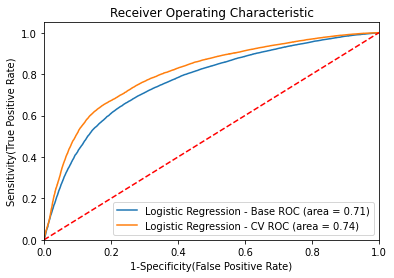

In [51]:
models = [
    {
        'label': 'Logistic Regression - Base',
        'model': pipe_LR,
    },
    {
        'label': 'Logistic Regression - CV',
        'model': best_model,
    }
]

display_multiple_models_roc_curve(models, X_train, y_train)

In [52]:
print("Test Report for Logistic Regression\n", classification_report(y_train, best_model.predict(X_train)))

Test Report for Logistic Regression
               precision    recall  f1-score   support

           0       0.71      0.82      0.76     28107
           1       0.78      0.66      0.71     27890

    accuracy                           0.74     55997
   macro avg       0.74      0.74      0.74     55997
weighted avg       0.74      0.74      0.74     55997



Confusion matrix, without normalization


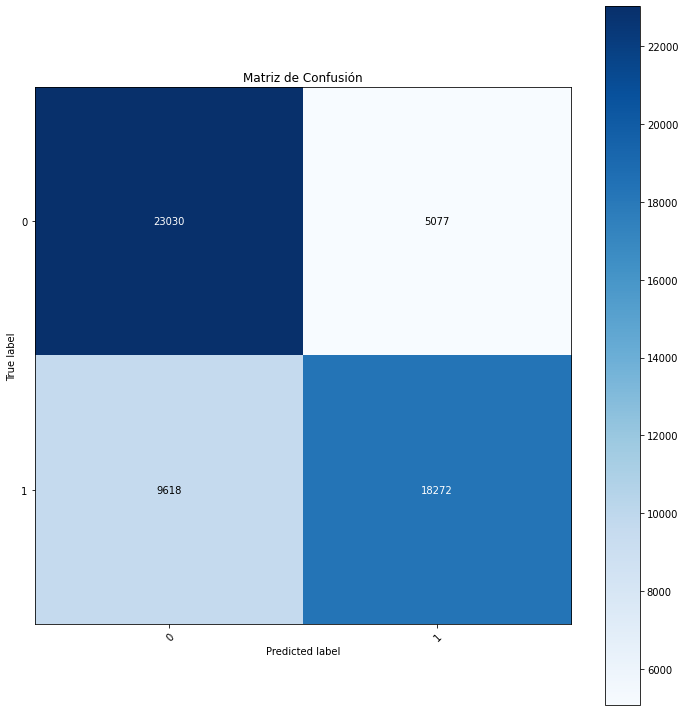

In [53]:
plot_confusion_matrix(y_true=y_train, y_pred= best_model.predict(X_train), classes=[0,1],
                      title='Matriz de Confusión')

### Evaluación

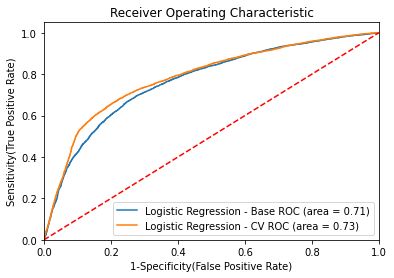

In [54]:
X_test, y_test = test.drop(['ECV'],axis=1), test['ECV']
display_multiple_models_roc_curve(models, X_test, y_test)

In [55]:
print("Test Report for Logistic Regression\n", classification_report(y_test, best_model.predict(X_test)))

Test Report for Logistic Regression
               precision    recall  f1-score   support

           0       0.69      0.81      0.74      6911
           1       0.78      0.65      0.70      7089

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.72     14000
weighted avg       0.73      0.73      0.72     14000



### Preguntas

- ¿Qué otros hiperparámetros deberíamos buscar para esta situación?
- ¿Que otros tipos de algoritmos de clasificación nos podrían servir para resolver este problema?